In [1]:
import json
import pandas as pd
from urllib.request import urlopen
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [2]:
url = "https://api.worldbank.org/v2/countries/CHN/indicators/NY.GDP.MKTP.CD?per_page=5000&format=json"
response = urlopen(url)
data_json = json.loads(response.read())
if isinstance(data_json, list) and len(data_json) > 1:
    # Normalize the data part (usually the second element in the list)
    df = pd.json_normalize(data_json[1])
else:
    df = pd.DataFrame()  # Fallback to an empty DataFrame if the structure is not as expected

df.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,CHN,2022,1.796317e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
1,CHN,2021,1.782046e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
2,CHN,2020,1.468774e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
3,CHN,2019,1.427997e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
4,CHN,2018,1.389491e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China


In [3]:
#Transformed number into trillion for easier visualization
df['value_billions'] = df['value'] / 1e9
df.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions
0,CHN,2022,1.796317e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,17963.170521
1,CHN,2021,1.782046e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,17820.459342
2,CHN,2020,1.468774e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,14687.743557
3,CHN,2019,1.427997e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,14279.968486
4,CHN,2018,1.389491e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,13894.907485


In [4]:
df.describe(include='all')

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions
count,63,63,6.300000e+01,63,63,63.0,63,63,63,63,63.000000
unique,1,63,NaN,1,1,NaN,1,1,1,1,NaN
top,CHN,2022,NaN,,,NaN,NY.GDP.MKTP.CD,GDP (current US$),CN,China,NaN
freq,63,1,NaN,63,63,NaN,63,63,63,63,NaN
mean,NaN,NaN,3.062319e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3062.319399
std,NaN,NaN,4.953679e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,4953.678954
min,NaN,NaN,4.720919e+10,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47.209188
25%,NaN,NaN,1.517400e+11,NaN,NaN,0.0,NaN,NaN,NaN,NaN,151.739995
50%,NaN,NaN,3.833733e+11,NaN,NaN,0.0,NaN,NaN,NaN,NaN,383.373318
75%,NaN,NaN,3.151223e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3151.223056


In [5]:
# Print the column names of the DataFrame
print(df.columns)

Index(['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal',
       'indicator.id', 'indicator.value', 'country.id', 'country.value',
       'value_billions'],
      dtype='object')


In [6]:
descriptive_stats = df['value'].describe()
print(descriptive_stats)

count    6.300000e+01
mean     3.062319e+12
std      4.953679e+12
min      4.720919e+10
25%      1.517400e+11
50%      3.833733e+11
75%      3.151223e+12
max      1.796317e+13
Name: value, dtype: float64


In [7]:
df.isnull().any().sum()

0

In [8]:
# Convert 'date' to a datetime object and then extract the year as an integer
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.year


# Define the time periods (for example, before and after the year 2000)
split_year = 2000
before_2000 = df[df['date'] < split_year]['value'].dropna()
after_2000 = df[df['date'] >= split_year]['value'].dropna()

# Check if the subsets are populated
print("Number of entries before 2000:", before_2000.size)
print("Number of entries after 2000:", after_2000.size)

# Perform the independent samples t-test, if both subsets are non-empty
if not before_2000.empty and not after_2000.empty:
    t_test_result = stats.ttest_ind(before_2000, after_2000)
    print("T-Test Result:", t_test_result)
else:
    print("One or both subsets are empty, t-test cannot be performed")


Number of entries before 2000: 40
Number of entries after 2000: 23
T-Test Result: Ttest_indResult(statistic=-8.706969262130112, pvalue=2.6986241889477673e-12)


In the analysis, an independent samples t-test was conducted to compare the mean GDP values of China between two distinct time periods: before and after the year 2000. This test helps determine whether there is a statistically significant difference in China's average GDP between these two eras. The t-test yielded a statistic of -8.706969262130116 and a p-value of approximately 2.70e-12. The negative test statistic indicates that the mean GDP in the period before 2000 was lower than the mean GDP after 2000. The extremely small p-value, much lower than the conventional alpha level of 0.05, suggests that this difference in means is statistically significant. In terms of hypothesis testing, the null hypothesis (that there is no difference in mean GDP between the two periods) is rejected, indicating a significant change in China's GDP around the year 2000. This result could reflect substantial economic shifts or policy changes around the turn of the millennium, warranting further investigation into the contextual factors influencing these economic trends.


The Shapiro-Wilk test is a statistical procedure used to assess whether a dataset is normally distributed. It compares the distribution of the data against the normal distribution by calculating a W statistic, which indicates how much the data deviates from normality. This test was chosen because it's particularly effective for small to moderate-sized datasets, offering high sensitivity to deviations from a normal distribution. 

In [9]:
# Perform the Shapiro-Wilk test for normality
# Ensure that you have no NaN values in the 'value' column
shapiro_test = stats.shapiro(df['value'].dropna())

# The Shapiro-Wilk test returns a tuple of the test statistic and the p-value
shapiro_stat, shapiro_p_value = shapiro_test

print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, P-Value: {shapiro_p_value}")

# Interpretation of the test
if shapiro_p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")


Shapiro-Wilk Test Statistic: 0.6551258563995361, P-Value: 6.807249902651691e-11
The data does not follow a normal distribution (reject H0).


To prove info above:

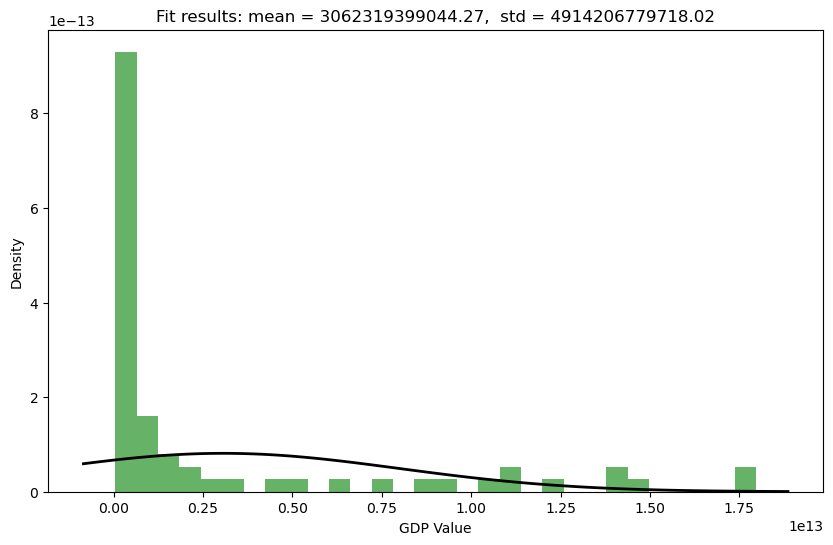

In [10]:
# Drop NaN values from the 'value' column for accurate representation
data = df['value'].dropna()

# Calculate mean and standard deviation of the data
mean = np.mean(data)
std = np.std(data)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the normal distribution with the same mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('GDP Value')
plt.ylabel('Density')

# Show the plot
plt.show()

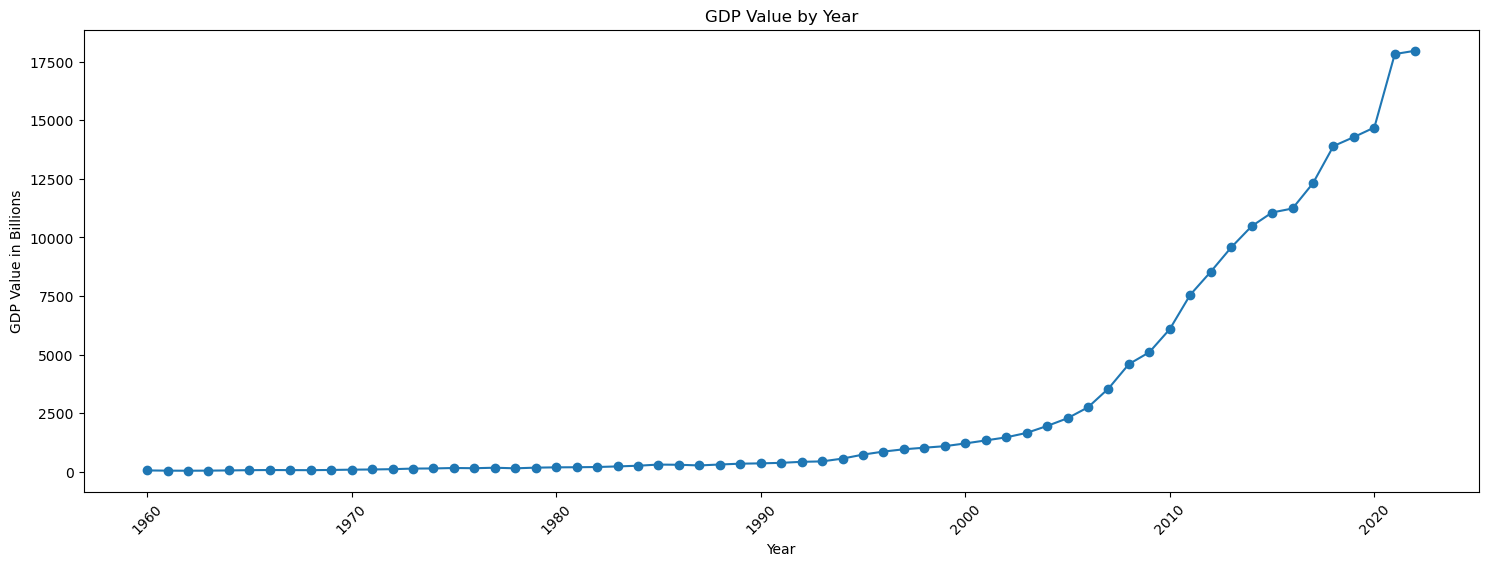

In [11]:
df = df.sort_values(by='date')

# Create a plot of 'value' by 'date'
plt.figure(figsize=(18, 6))  # Set the figure size
plt.plot(df['date'], df['value_billions'], marker='o')  # Plot 'value' against 'date'

# Add titles and labels
plt.title('GDP Value by Year')
plt.xlabel('Year')
plt.ylabel('GDP Value in Billions')

plt.xticks(rotation=45)  # Rotate the labels by 45 degrees

# Show the plot
plt.show()

In [12]:
gdp_date_corr = df['value'].corr(df['date'])

print("Correltion of year with value of GDP: ", gdp_date_corr )

Correltion of year with value of GDP:  0.7849067828389961


<Axes: ylabel='Frequency'>

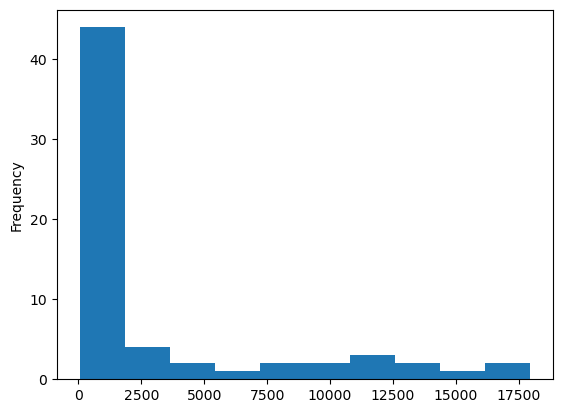

In [13]:
df['value_billions'].plot(kind='hist')

Since initial dataset does not have a lot of information except value of GDP I will merge it with data from other sources.

In [14]:
#adding new dataset to extract inflation as new feature

filename = 'Countries_inflation1960-2021.csv'

df_inflation = pd.read_csv(filename)

#filter data set only for China inflation info

china_inflation_df = df_inflation[df_inflation['Country Name'] == 'China']

china_inflation_df.head()


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.619524,2.62105,1.921642,1.437024,2.000002,1.593136,2.07479,2.899234,2.419422,0.981015


Merging newly made column with existing df


In [15]:
#rename 'date' column in df to year for consistency
df = df.rename(columns = {'date': 'Year' })

#making sure year is in format int
df['Year'] = df['Year'].astype(int)


china_inflation_df = pd.DataFrame(china_inflation_df)
china_inflation_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.619524,2.62105,1.921642,1.437024,2.000002,1.593136,2.07479,2.899234,2.419422,0.981015


In [16]:
year_columns = china_inflation_df.columns[4:]

china_long_format = pd.melt(china_inflation_df, 
                            value_vars=year_columns, 
                            var_name='Year', 
                            value_name='inflation_rate')

china_long_format['Year'] = china_long_format['Year'].astype(int)

merged_df = pd.merge(df, china_long_format, on='Year')


Adding another dataset with information about export, import, household consumption, capital investment & government spending.

In [17]:
filename = 'china_economy_data.csv'

df_china_economy = pd.read_csv(filename)

df_china_economy.head()

,Country,Code,ContinentCode,Year,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,China,CHN,AS,1960,23.64,30.13,2.57,2.64,7.43
1,China,CHN,AS,1961,11.42,33.17,1.94,1.75,7.16
2,China,CHN,AS,1962,7.43,34.07,1.91,1.37,5.99
3,China,CHN,AS,1963,11.03,34.29,2.03,1.45,6.86
4,China,CHN,AS,1964,14.54,36.14,2.25,1.71,7.57


In [18]:
df_china_economy['Year'] = df_china_economy['Year'].astype(int)
merged_df  = pd.merge(merged_df, df_china_economy, on='Year')

merged_df.head()

,countryiso3code,Year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions,inflation_rate,Country,Code,ContinentCode,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,CHN,1960,5.971625e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,59.716252,NaN,China,CHN,AS,23.64,30.13,2.57,2.64,7.43
1,CHN,1961,5.005669e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,50.056688,NaN,China,CHN,AS,11.42,33.17,1.94,1.75,7.16
2,CHN,1962,4.720919e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,47.209188,NaN,China,CHN,AS,7.43,34.07,1.91,1.37,5.99
3,CHN,1963,5.070662e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,50.706617,NaN,China,CHN,AS,11.03,34.29,2.03,1.45,6.86
4,CHN,1964,5.970813e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,59.708128,NaN,China,CHN,AS,14.54,36.14,2.25,1.71,7.57


In [19]:
#dropping useless columns and value column, since all other info is in billions
columns_to_drop = ['value','countryiso3code', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value', 'Country', 'Code', 'ContinentCode']
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

merged_df.head()

,Year,value_billions,inflation_rate,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,1960,59.716252,NaN,23.64,30.13,2.57,2.64,7.43
1,1961,50.056688,NaN,11.42,33.17,1.94,1.75,7.16
2,1962,47.209188,NaN,7.43,34.07,1.91,1.37,5.99
3,1963,50.706617,NaN,11.03,34.29,2.03,1.45,6.86
4,1964,59.708128,NaN,14.54,36.14,2.25,1.71,7.57


In [20]:
merged_df.shape

(62, 8)